# Import libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import itertools
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report

# Load dataset

In [2]:
data = "dataset/Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


In [3]:
df.columns

Index(['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'style', 'summary', 'unixReviewTime', 'verified',
       'vote'],
      dtype='object')

How many reviews are verified?

In [4]:
df.groupby('verified')['unixReviewTime'].count()

verified
False    141113
True     987324
Name: unixReviewTime, dtype: int64

#### Open point: how do we address it? (If we want to do it, of course :) )
# Filtering the dataset
The first operation we will perform is the removal of punctuation characters and lowercase all letters: these operation will be useful for reducing the number of features

In [5]:
df['reviewText'] = df['reviewText'].str.replace('[.,;:;!?]+', '')

In [6]:
df['reviewText'] = df['reviewText'].str.lower()

In [7]:
X = df.reviewText[df.reviewText.notnull()].values
y = df.overall[df.reviewText.notnull()].values

In [8]:
X.shape

(1127672,)

In [9]:
y.shape

(1127672,)

How are the values split?

In [10]:
star_value, counts = np.unique(y, return_counts=True)
dict(zip(star_value, counts))

{1: 81506, 2: 57166, 3: 98214, 4: 184351, 5: 706435}

In [11]:
dict(zip(star_value, counts/len(y)))

{1: 0.07227810923743784,
 2: 0.05069381876999695,
 3: 0.08709447427975511,
 4: 0.16347927411516824,
 5: 0.6264543235976419}

Imbalanced dataset!
We'd like to split the ratings as follows:
- 1,2 and 3 will be considered negative
- 4 and 5 will be considered positive

The main reason why we'd like to proceed as follows is that, on Amazon, the most restrictive filter is the "4 star +" one and is used for filtering the returned results: a given vendor would like to have her/his products shown after this phase.

In [12]:
def int2sent(n):
    if n >= 4:
        return "positive"
    if n <= 3:
        return "negative"

In [13]:
"""
vectInt2sent = np.vectorize(int2sent)
ysent = vectInt2sent(y)
for c in np.unique(ysent):
    print("{:10s} {}".format(c, np.sum(ysent==c)/len(ysent)))
"""

'\nvectInt2sent = np.vectorize(int2sent)\nysent = vectInt2sent(y)\nfor c in np.unique(ysent):\n    print("{:10s} {}".format(c, np.sum(ysent==c)/len(ysent)))\n'

In [14]:
sentiment_is_positive = y > 3

In [15]:
sentiment_categories, counts = np.unique(sentiment_is_positive, return_counts=True)
dict(zip(sentiment_categories, counts))

{False: 236886, True: 890786}

In [16]:
dict(zip(sentiment_categories, counts/len(sentiment_is_positive)))

{False: 0.2100664022871899, True: 0.7899335977128101}

# Text Preprocessing

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Train-test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_is_positive, test_size=0.33, random_state=42)

In [19]:
X_train[0]

'this case is nice well-made and fits snugly on the phone  i purchased this case along with another brand that was 100% tpu material  while i can see that this case is very scratch resistant i think i prefer a case that is 100% tpu because of improved grip and non-slip properties  the hard polycarbonate material on the back of this case will let the phone slide on a smooth surface like a table  i just prefer a case that has more of a "grippy" back so that the phone doesn\'t slide on a smooth surface  but that\'s just my preference'

In [20]:
y_train[0]

True

## Tokenization

In [21]:
from nltk.tokenize import word_tokenize

In [22]:
X_train_tokenized = [word_tokenize(sentence) for sentence in X_train]

In [23]:
X_test_tokenized = [word_tokenize(sentence) for sentence in X_test]

In [24]:
X_train[0]

'this case is nice well-made and fits snugly on the phone  i purchased this case along with another brand that was 100% tpu material  while i can see that this case is very scratch resistant i think i prefer a case that is 100% tpu because of improved grip and non-slip properties  the hard polycarbonate material on the back of this case will let the phone slide on a smooth surface like a table  i just prefer a case that has more of a "grippy" back so that the phone doesn\'t slide on a smooth surface  but that\'s just my preference'

In [25]:
X_train_tokenized[0]

['this',
 'case',
 'is',
 'nice',
 'well-made',
 'and',
 'fits',
 'snugly',
 'on',
 'the',
 'phone',
 'i',
 'purchased',
 'this',
 'case',
 'along',
 'with',
 'another',
 'brand',
 'that',
 'was',
 '100',
 '%',
 'tpu',
 'material',
 'while',
 'i',
 'can',
 'see',
 'that',
 'this',
 'case',
 'is',
 'very',
 'scratch',
 'resistant',
 'i',
 'think',
 'i',
 'prefer',
 'a',
 'case',
 'that',
 'is',
 '100',
 '%',
 'tpu',
 'because',
 'of',
 'improved',
 'grip',
 'and',
 'non-slip',
 'properties',
 'the',
 'hard',
 'polycarbonate',
 'material',
 'on',
 'the',
 'back',
 'of',
 'this',
 'case',
 'will',
 'let',
 'the',
 'phone',
 'slide',
 'on',
 'a',
 'smooth',
 'surface',
 'like',
 'a',
 'table',
 'i',
 'just',
 'prefer',
 'a',
 'case',
 'that',
 'has',
 'more',
 'of',
 'a',
 '``',
 'grippy',
 "''",
 'back',
 'so',
 'that',
 'the',
 'phone',
 'does',
 "n't",
 'slide',
 'on',
 'a',
 'smooth',
 'surface',
 'but',
 'that',
 "'s",
 'just',
 'my',
 'preference']

In [26]:
from joblib import dump, load

In [27]:
#dump(X_train_tokenized, 'X_train_tokenized.joblib')
#dump(X_test_tokenized, 'X_test_tokenized.joblib')

In [28]:
len(X_train_tokenized)

755540

## Stemming
Because it is necessary to install Visual C++ before installing the package 'pyStemmer' via pip https://support.microsoft.com/it-it/help/2977003/the-latest-supported-visual-c-downloads I will use nltk library even though it is less efficient
### PorterStemmer

In [29]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [30]:
X_train_tokenized_stemmed_ps = []
for sentence in X_train_tokenized:
    X_train_tokenized_stemmed_ps.append([ps.stem(word) for word in sentence])

In [31]:
X_train_tokenized_stemmed_ps[0]

['thi',
 'case',
 'is',
 'nice',
 'well-mad',
 'and',
 'fit',
 'snugli',
 'on',
 'the',
 'phone',
 'i',
 'purchas',
 'thi',
 'case',
 'along',
 'with',
 'anoth',
 'brand',
 'that',
 'wa',
 '100',
 '%',
 'tpu',
 'materi',
 'while',
 'i',
 'can',
 'see',
 'that',
 'thi',
 'case',
 'is',
 'veri',
 'scratch',
 'resist',
 'i',
 'think',
 'i',
 'prefer',
 'a',
 'case',
 'that',
 'is',
 '100',
 '%',
 'tpu',
 'becaus',
 'of',
 'improv',
 'grip',
 'and',
 'non-slip',
 'properti',
 'the',
 'hard',
 'polycarbon',
 'materi',
 'on',
 'the',
 'back',
 'of',
 'thi',
 'case',
 'will',
 'let',
 'the',
 'phone',
 'slide',
 'on',
 'a',
 'smooth',
 'surfac',
 'like',
 'a',
 'tabl',
 'i',
 'just',
 'prefer',
 'a',
 'case',
 'that',
 'ha',
 'more',
 'of',
 'a',
 '``',
 'grippi',
 "''",
 'back',
 'so',
 'that',
 'the',
 'phone',
 'doe',
 "n't",
 'slide',
 'on',
 'a',
 'smooth',
 'surfac',
 'but',
 'that',
 "'s",
 'just',
 'my',
 'prefer']

In [32]:
X_test_tokenized_stemmed_ps = []
for sentence in X_test_tokenized:
    X_test_tokenized_stemmed_ps.append([ps.stem(word) for word in sentence])

### Lancaster stemmer

In [33]:
from nltk.stem import LancasterStemmer
ls_stemmer = LancasterStemmer()

In [34]:
X_train_tokenized_stemmed_ls = []
for sentence in X_train_tokenized:
    X_train_tokenized_stemmed_ls.append([ls_stemmer.stem(word) for word in sentence])

In [35]:
X_test_tokenized_stemmed_ls = []
for sentence in X_test_tokenized:
    X_test_tokenized_stemmed_ls.append([ls_stemmer.stem(word) for word in sentence])

## TF-IDF
For computing TF-IDF matrix we need to rebuild the sentences. Let's do it:

### Porter stemmer

In [36]:
X_train_tokenized_ps_sent = []
for sentence in X_train_tokenized_stemmed_ps:
    X_train_tokenized_ps_sent.append(" ".join(sentence))
X_train_tokenized_ps_sent[0]

"thi case is nice well-mad and fit snugli on the phone i purchas thi case along with anoth brand that wa 100 % tpu materi while i can see that thi case is veri scratch resist i think i prefer a case that is 100 % tpu becaus of improv grip and non-slip properti the hard polycarbon materi on the back of thi case will let the phone slide on a smooth surfac like a tabl i just prefer a case that ha more of a `` grippi '' back so that the phone doe n't slide on a smooth surfac but that 's just my prefer"

In [37]:
X_test_tokenized_ps_sent = []
for sentence in X_test_tokenized_stemmed_ps:
    X_test_tokenized_ps_sent.append(" ".join(sentence))

### LancasterStemmer

In [40]:
X_train_tokenized_ls_sent = []
for sentence in X_train_tokenized_stemmed_ls:
    X_train_tokenized_ls_sent.append(" ".join(sentence))
X_train_tokenized_ls_sent[0]

"thi cas is nic well-made and fit snug on the phon i purchas thi cas along with anoth brand that was 100 % tpu mat whil i can see that thi cas is very scratch resist i think i pref a cas that is 100 % tpu becaus of improv grip and non-slip property the hard polycarbon mat on the back of thi cas wil let the phon slid on a smoo surfac lik a tabl i just pref a cas that has mor of a `` grippy '' back so that the phon doe n't slid on a smoo surfac but that 's just my pref"

In [41]:
X_test_tokenized_ls_sent = []
for sentence in X_test_tokenized_stemmed_ls:
    X_test_tokenized_ls_sent.append(" ".join(sentence))

## Compute TF-IDF matrix
For avoiding a high number of features I will set the following two constrainst:
- A term should have a frequency >= 5 in the entire corpus
- The best 50 000 features are kept

### Porter stemmer

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_ps = TfidfVectorizer(stop_words='english', min_df= 5, max_features = 50000)
X_train_tfidf_ps = tfidf_vect_ps.fit_transform(X_train_tokenized_ps_sent)

In [43]:
print(X_train_tfidf_ps)

  (0, 19215)	0.17290276362086485
  (0, 4244)	0.30565518658691787
  (0, 13172)	0.07140875398966193
  (0, 11874)	0.16730176521204945
  (0, 7922)	0.06293765351428794
  (0, 17771)	0.14764036309134135
  (0, 14475)	0.14148608379827002
  (0, 15495)	0.08540166872381717
  (0, 2459)	0.09552543095217728
  (0, 3730)	0.10892441946063029
  (0, 20840)	0.058859521459941146
  (0, 85)	0.23912801925190572
  (0, 19604)	0.2738745227658776
  (0, 12071)	0.22034211271670573
  (0, 20607)	0.05824827179164364
  (0, 16894)	0.09900335695471729
  (0, 16211)	0.1341376055341389
  (0, 19247)	0.09660090436263118
  (0, 15049)	0.3795742798360569
  (0, 3250)	0.08024785635003766
  (0, 10102)	0.13492756079486148
  (0, 9041)	0.10689969362917563
  (0, 13272)	0.1330029236010536
  (0, 17602)	0.11804286397093974
  (0, 15327)	0.19759228376977667
  :	:
  (755535, 6163)	0.27127353189712117
  (755535, 7089)	0.37326453500286055
  (755535, 8859)	0.29941111209803173
  (755535, 20421)	0.2106218653483153
  (755535, 7858)	0.35151038399452

In [44]:
dump(tfidf_vect_ps, 'tfidf_vect_ps.joblib')

['tfidf_vect_ps.joblib']

In [45]:
X_test_tfidf_ps = tfidf_vect_ps.transform(X_test_tokenized_ps_sent)

In [46]:
len(tfidf_vect_ps.get_feature_names())

21763

### Lancaster stemmer

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_ls = TfidfVectorizer(stop_words='english', min_df= 5, max_features = 50000)
X_train_tfidf_ls = tfidf_vect_ls.fit_transform(X_train_tokenized_ls_sent)

In [48]:
dump(tfidf_vect_ls, 'tfidf_vect_ls.joblib')

['tfidf_vect_ls.joblib']

In [49]:
X_test_tfidf_ls = tfidf_vect_ls.transform(X_test_tokenized_ls_sent)

In [50]:
len(tfidf_vect_ls.get_feature_names())

20136

### Store stemmed dataset

In [51]:
dump(X_train_tfidf_ps, 'X_train_tfidf_ps.joblib')
dump(X_test_tfidf_ps, 'X_test_tfidf_ps.joblib')

['X_test_tfidf_ps.joblib']

In [52]:
dump(X_train_tfidf_ls, 'X_train_tfidf_ls.joblib')
dump(X_test_tfidf_ls, 'X_test_tfidf_ls.joblib')

['X_test_tfidf_ls.joblib']

# Classifiers
## Multinomial Naive-Bayes
### Porter

In [53]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_tfidf_ps, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Evaluate performances

In [54]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

In [55]:
train_score = clf.score(X_train_tfidf_ps, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ps, y_test)    # Test Accuracy

In [56]:
print(train_score)

0.8437303120946608


In [57]:
print(test_score)

0.8405915105392711


In [58]:
predictions = clf.predict(X_test_tfidf_ps)
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [59]:
cm

array([[ 23153,  55071],
       [  4250, 289658]], dtype=int64)

In [60]:
proba = clf.predict_proba(X_test_tfidf_ps)
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [61]:
auc_score = auc(recall, precision)

In [62]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.84373
Test Accuracy        0.84059
Test Precision       0.84025
Test Recall          0.98554
F1                   0.90711
F2                   0.95260
P/R AUC              0.96567


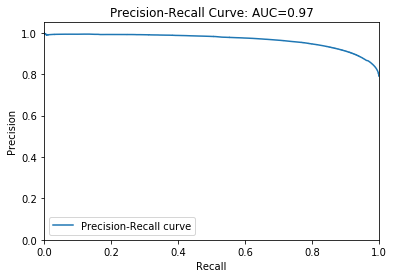

In [63]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

In [64]:
classification_report(y_test,predictions)

'             precision    recall  f1-score   support\n\n      False       0.84      0.30      0.44     78224\n       True       0.84      0.99      0.91    293908\n\navg / total       0.84      0.84      0.81    372132\n'

### Lancaster

In [65]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_ls, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
train_score = clf.score(X_train_tfidf_ls, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ls, y_test)    # Test Accuracy

In [67]:
train_score

0.8416337983429071

In [68]:
test_score

0.8389415583717605

In [69]:
predictions = clf.predict(X_test_tfidf_ls)
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)
proba = clf.predict_proba(X_test_tfidf_ls)
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [70]:
auc_score = auc(recall, precision)

In [71]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.84163
Test Accuracy        0.83894
Test Precision       0.83795
Test Recall          0.98694
F1                   0.90636
F2                   0.95305
P/R AUC              0.96463


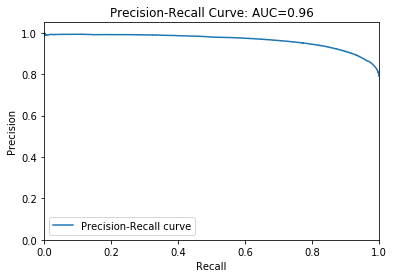

In [72]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

In [73]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.85      0.28      0.42     78224
       True       0.84      0.99      0.91    293908

avg / total       0.84      0.84      0.81    372132



## Random forest
### Porter

In [74]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_ps, y_train) # it takes around 30 minutes

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 23.6min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [75]:
train_score = clf.score(X_train_tfidf_ps, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ps, y_test)    # Test Accuracy

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished


In [76]:
predictions = clf.predict(X_test_tfidf_ps)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished


In [77]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.83      0.49      0.62     78224
       True       0.88      0.97      0.92    293908

avg / total       0.87      0.87      0.86    372132



Results are more encouraging! The problem is that it's way slower than Multinomial NB.
## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

In [78]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_ps_pca = tsvd.fit_transform(X_train_tfidf_ps)
X_test_tfidf_ps_pca = tsvd.transform(X_test_tfidf_ps)

In [79]:
X_train_tfidf_ps

<755540x21763 sparse matrix of type '<class 'numpy.float64'>'
	with 14537542 stored elements in Compressed Sparse Row format>

In [80]:
print("train with old features: ",np.array(X_train_tfidf_ps).shape)
print("train with new features:" ,np.array(X_train_tfidf_ps_pca).shape)

train with old features:  ()
train with new features: (755540, 500)


### Store SVD-transformed dataset

In [81]:
dump(X_train_tfidf_ps_pca, 'X_train_tfidf_ps_pca.joblib')
dump(X_test_tfidf_ps_pca, 'X_test_tfidf_ps_pca.joblib')

['X_test_tfidf_ps_pca.joblib']

### Classifiers
Multinomial NB won't be used for the following reasons: https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb
#### Randomforest

In [82]:
from sklearn.naive_bayes import MultinomialNB

clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_ps_pca, y_train)

building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [83]:
predictions = clf.predict(X_test_tfidf_ps_pca)
print(classification_report(y_test,predictions))

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.8s


             precision    recall  f1-score   support

      False       0.82      0.32      0.46     78224
       True       0.85      0.98      0.91    293908

avg / total       0.84      0.84      0.81    372132



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.1s finished
